## Project Overview
**This project aims to detect anomalies in transistor images using a PatchCore-style pipeline with a ResNet-50 backbone and memory bank–based scoring.**

## Dataset Composition
**Train set**
- train/good — normal samples

**Test set**
- test/good — normal samples
- test/bent_lead, test/cut_lead, test/damaged_case, test/misplaced — defect samples (BAD)

### 1. Setup
- Imports : Core libs for image processing, deep learning, evaluation, and FAISS.
- Configuration : Paths, device, normalization constants, and random seeds.
- Utilities : Image loading, tensor conversion, Gaussian blur, and top-percent scoring.

In [1]:
# =========================
# Imports 
# =========================
import os, glob, random, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import models

from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_fscore_support, confusion_matrix
)

import faiss
from tqdm import tqdm

# =========================
# Configuration
# =========================
ROOT      = r"./"
TRAIN_DIR = os.path.join(ROOT, "train", "good")
TEST_DIR  = os.path.join(ROOT, "test")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

IM_MEAN = np.array([0.485, 0.456, 0.406], np.float32)
IM_STD  = np.array([0.229, 0.224, 0.225], np.float32)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# Utilities
# =========================
def list_images(dir_path):
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.tif","*.tiff")
    files = []
    for e in exts: files += list(Path(dir_path).glob(e))
    files = [str(p) for p in sorted(files)]
    return files

def load_bgr(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    if im is None: raise FileNotFoundError(path)
    if IMG_SIZE is not None:
        im = cv2.resize(im, IMG_SIZE, interpolation=cv2.INTER_AREA)
    return im

def load_rgb(path):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def bgr_to_tensor(im_bgr):
    im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    im_rgb = (im_rgb - IM_MEAN) / IM_STD
    return torch.from_numpy(im_rgb).permute(2,0,1).unsqueeze(0)

def gaussian_blur(map2d, ksize=7, sigma=2.0):
    k = int(ksize); k = k if k % 2 == 1 else k + 1
    return cv2.GaussianBlur(map2d, (k, k), sigmaX=sigma, sigmaY=sigma,
                            borderType=cv2.BORDER_REFLECT_101)

def top_percent_mean(arr, p=0.02):
    flat = arr.ravel()
    p = float(np.clip(p, 1e-4, 0.5))
    k = max(1, int(len(flat) * p))
    idx = np.argpartition(flat, -k)[-k:]
    return float(flat[idx].mean())

#### 1-1. Sample Image Preview
- Displays GOOD training image and BAD example from each defect class to provide a quick visual check of the dataset.

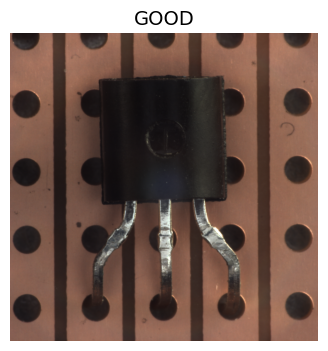

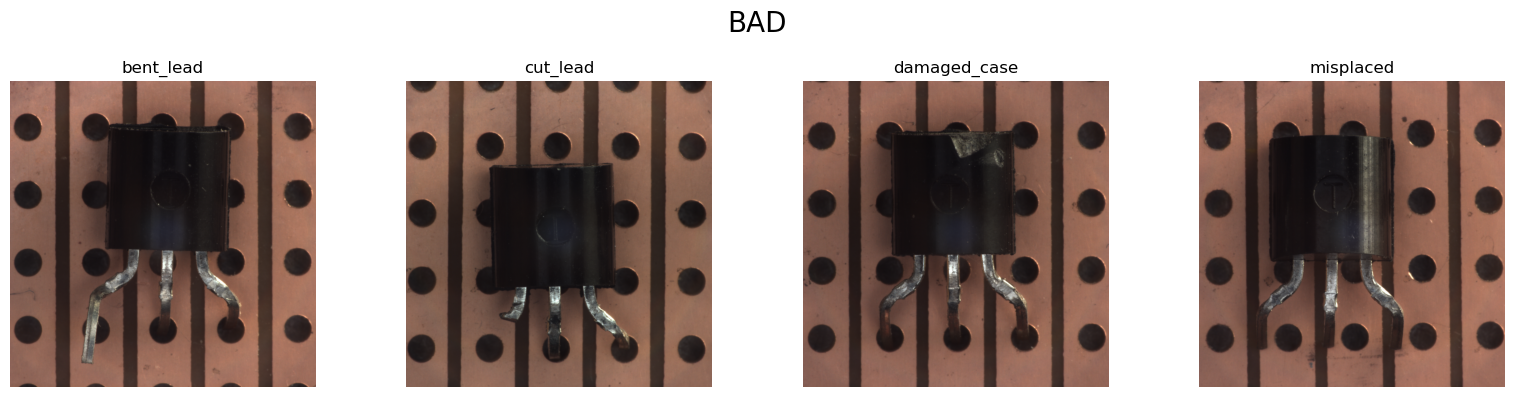

In [2]:
# Show GOOD image
good_path = list_images(TRAIN_DIR)[0]
good_img = load_rgb(good_path)
plt.figure(figsize=(4, 4))
plt.imshow(good_img); plt.axis("off"); plt.title("GOOD", fontsize=14)
plt.show()

# Show BAD sample per class
bad_examples = []
for cls_dir in sorted(Path(TEST_DIR).iterdir()):
    if cls_dir.is_dir() and cls_dir.name.lower() != "good":
        imgs = list_images(str(cls_dir))
        if imgs: 
            bad_examples.append((cls_dir.name, imgs[0]))

cols = len(bad_examples)
fig = plt.figure(figsize=(4 * cols, 4))
fig.suptitle("BAD", fontsize=20, y=0.98)
for i, (cls, p) in enumerate(bad_examples):
    ax = plt.subplot(1, cols, i+1)
    ax.imshow(load_rgb(p))
    ax.axis("off")
    ax.set_title(cls, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 2. Backbone Setup

- Backbone Construction: Builds a ResNet-50 with hooks on layer2 & 3 to capture feature maps.
- Feature Map Visualization : Shows normalized mean maps of layer2, layer3, and their combination.

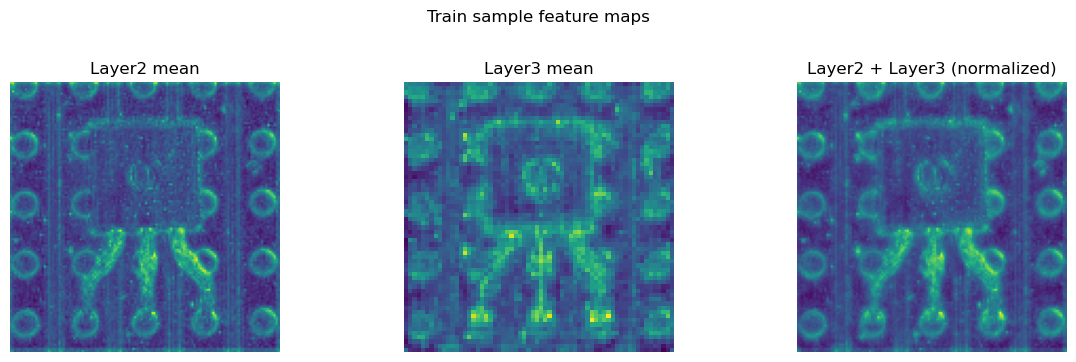

In [3]:
def build_backbone():
    try:
        from torchvision.models import resnet50, ResNet50_Weights
        m = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    except Exception:
        m = models.resnet50(pretrained=True)
    m.eval().to(DEVICE)
    for p in m.parameters(): 
        p.requires_grad = False

    feats = {}
    def hook(name):
        def _h(_, __, out): feats[name] = out
        return _h
    m.layer2.register_forward_hook(hook("l2"))
    m.layer3.register_forward_hook(hook("l3"))
    return m, feats

def extract_feats(backbone, feats_cache, img_bgr):
    ten = bgr_to_tensor(img_bgr).to(DEVICE)
    with torch.no_grad():
        _ = backbone(ten)
        f2 = feats_cache["l2"].squeeze(0)
        f3 = feats_cache["l3"].squeeze(0)
    return f2, f3

def viz_feature_maps(f2, f3, title="Train sample feature maps"):
    fmap2 = f2.mean(0).detach().cpu().numpy()
    fmap3 = f3.mean(0).detach().cpu().numpy()
    
    if fmap2.shape != fmap3.shape:
        fmap3r = cv2.resize(fmap3, (fmap2.shape[1], fmap2.shape[0]),
                            interpolation=cv2.INTER_CUBIC)
    else:
        fmap3r = fmap3    
    fmap_sum = fmap2 + fmap3r

    def _norm(x):
        return (x - x.min()) / (x.ptp() + 1e-8)

    # Plot feature maps
    plt.figure(figsize=(12, 3.5))
    plt.suptitle(title, y=1.02)
    plt.subplot(1, 3, 1)
    plt.title("Layer2 mean"); plt.axis("off")
    plt.imshow(_norm(fmap2), cmap="viridis")
    plt.subplot(1, 3, 2)
    plt.title("Layer3 mean"); plt.axis("off")
    plt.imshow(_norm(fmap3), cmap="viridis")
    plt.subplot(1, 3, 3)
    plt.title("Layer2 + Layer3 (normalized)"); plt.axis("off")
    plt.imshow(_norm(fmap_sum), cmap="viridis")
    plt.tight_layout()
    plt.show()

# ======run======
backbone, feats_cache = build_backbone()
f2, f3 = extract_feats(backbone, feats_cache, cv2.imread(good_path))
viz_feature_maps(f2, f3, title="Train sample feature maps")

### 3. Feature Extraction & Scoring Pipeline

- Patch Embeddings : Extracts layer2 & layer3 feature patches with optional normalization and downsampling.

- Dimensionality Reduction & Sampling : Uses PCA for compression and k-center coreset for a compact set.

- Indexing & Scoring : FAISS kNN builds distance maps, then Gaussian smoothing and top-percent averaging score anomalies.

In [4]:
# ---- Feature & pipeline options
IMG_SIZE          = None
PATCH_FROM_LAYER2 = True
CHANNELWISE_L2    = True
FEAT_DOWNSAMPLE   = 2

S_PER_IMG          = 500
PCA_DIM            = 256
PCA_FIT_SUBSAMPLE  = 50_000
CORESET_RATIO      = 0.01
KNN_K              = 5

TOP_PERCENT  = 0.02
GAUSS_KSIZE  = 7
GAUSS_SIGMA  = 2.0
TAU_PCTL     = 90

# =========================
# Features
# =========================
def extract_patch_embeddings(backbone, feats_cache, img_bgr):
    ten = bgr_to_tensor(img_bgr).to(DEVICE)
    with torch.no_grad():
        _ = backbone(ten)
        f2 = feats_cache["l2"]
        f3 = feats_cache["l3"]
        if PATCH_FROM_LAYER2:
            f3u = F.interpolate(f3, size=f2.shape[-2:], mode="bilinear", align_corners=False)
            f = torch.cat([f2, f3u], dim=1)
        else:
            f2d = F.interpolate(f2, size=f3.shape[-2:], mode="bilinear", align_corners=False)
            f = torch.cat([f2d, f3], dim=1)
        if CHANNELWISE_L2:
            f = F.normalize(f, p=2, dim=1)
        if FEAT_DOWNSAMPLE and FEAT_DOWNSAMPLE > 1:
            f = F.avg_pool2d(f, kernel_size=FEAT_DOWNSAMPLE, stride=FEAT_DOWNSAMPLE)
        f = f.squeeze(0)
        C,H,W = f.shape
        emb = f.permute(1,2,0).reshape(-1, C).contiguous().cpu().numpy().astype(np.float32)
    return emb, (H, W)

# =========================
# PCA / Coreset / FAISS / Scoring  
# =========================
def fit_pca(cand_matrix, pca_dim=PCA_DIM, fit_subsample=PCA_FIT_SUBSAMPLE, seed=SEED):
    n = len(cand_matrix)
    if n > fit_subsample:
        rng = np.random.default_rng(seed)         
        idx = rng.choice(n, fit_subsample, replace=False)
        X = cand_matrix[idx]
    else:
        X = cand_matrix
    pca = PCA(n_components=pca_dim, svd_solver="randomized", random_state=seed)
    pca.fit(X.astype(np.float32))
    return pca

def apply_pca(pca, X):
    return pca.transform(X.astype(np.float32)).astype(np.float32)

def coreset_k_center(X, ratio=CORESET_RATIO, seed=SEED):
    N,_ = X.shape
    M = max(1, int(N*ratio))
    rng = np.random.default_rng(seed)             
    centers = [int(rng.integers(0, N))]
    dmin = ((X - X[centers[0]])**2).sum(axis=1)
    for _ in tqdm(range(1, M), desc=f"coreset {N:,}->{M:,}"):
        c = int(np.argmax(dmin)); centers.append(c)
        dmin = np.minimum(dmin, ((X - X[c])**2).sum(axis=1))
    return np.array(sorted(set(centers)), dtype=np.int64)

def build_faiss_index(vecs):
    D = int(vecs.shape[1])
    index = faiss.IndexFlatL2(D)
    index.add(vecs.astype(np.float32))
    return index

def distance_map(index, emb, hw, k=KNN_K):
    D,_ = index.search(emb.astype(np.float32), int(k))
    return D.mean(axis=1).reshape(hw)

def score_from_map(dm):
    sm = gaussian_blur(dm, GAUSS_KSIZE, GAUSS_SIGMA)
    return top_percent_mean(sm, TOP_PERCENT), sm

### 4-1. Training Bank & Threshold Setup
#### Stage 1: Train Bank Construction

- Builds a compact bank of patch embeddings using PCA and coreset sampling.

#### Stage 2: Threshold Estimation (LOO)

- Derives τ by leave-one-out scoring on training images and taking the chosen percentile.

In [5]:
# =========================
# Train bank & LOO τ  
# =========================
def stage1_build_bank(backbone, feats_cache, seed=SEED):
    train_paths = list_images(TRAIN_DIR)
    cand_chunks, img_ranges, cur = [], [], 0
    rng = np.random.default_rng(seed)             
    for p in tqdm(train_paths, desc="collect train candidates"):
        emb, _ = extract_patch_embeddings(backbone, feats_cache, load_bgr(p))
        if len(emb) > S_PER_IMG:
            emb = emb[rng.choice(len(emb), S_PER_IMG, replace=False)]
        cand_chunks.append(emb)
        img_ranges.append((cur, cur + len(emb)))
        cur += len(emb)

    X_cand = np.concatenate(cand_chunks, axis=0).astype(np.float32)
    pca = fit_pca(X_cand, seed=seed)              
    X_pca = apply_pca(pca, X_cand)
    center_idx = coreset_k_center(X_pca, ratio=CORESET_RATIO, seed=seed)  
    bank_vecs  = X_pca[center_idx].astype(np.float32)

    center_img_id = np.empty(len(center_idx), dtype=np.int32)
    for ci, ridx in enumerate(center_idx):
        for img_id, (s,e) in enumerate(img_ranges):
            if s <= ridx < e:
                center_img_id[ci] = img_id; break
    return pca, bank_vecs, center_img_id, train_paths

def stage2_compute_tau(backbone, feats_cache, pca, bank_vecs, center_img_id, train_paths):
    loo_scores = []
    for img_id, p in enumerate(tqdm(train_paths, desc="LOO on train")):
        keep = (center_img_id != img_id)
        bank_loo = bank_vecs[keep] if keep.any() else bank_vecs
        index = build_faiss_index(bank_loo)
        emb, hw = extract_patch_embeddings(backbone, feats_cache, load_bgr(p))
        dm = distance_map(index, apply_pca(pca, emb), hw, k=KNN_K)
        s, _ = score_from_map(dm); loo_scores.append(s)
    return float(np.percentile(np.asarray(loo_scores, np.float32), TAU_PCTL))

# =========================
# Eval helpers & Plots
# =========================
def test_set_paths():
    good = list_images(os.path.join(TEST_DIR, "good"))
    bad  = []
    for d in sorted(Path(TEST_DIR).iterdir()):
        if d.is_dir() and d.name.lower() != "good":
            bad += list_images(str(d))
    return good, bad

def scores_for_paths(backbone, feats_cache, pca, bank_vecs, paths):
    index = build_faiss_index(bank_vecs)
    scores = []
    for p in paths:
        emb, hw = extract_patch_embeddings(backbone, feats_cache, load_bgr(p))
        dm = distance_map(index, apply_pca(pca, emb), hw, k=KNN_K)
        s,_ = score_from_map(dm); scores.append(s)
    return np.array(scores, np.float32)

def plot_score_hist(scores_good, scores_bad, tau, bins=40):
    plt.figure(figsize=(7,5))
    plt.hist(scores_good, bins=bins, alpha=0.5, label="GOOD", color="g")
    plt.hist(scores_bad,  bins=bins, alpha=0.7, label="BAD",  color="r")
    plt.axvline(tau, linestyle="--", color="k", label=f"τ={tau:.4f}")
    plt.xlabel("Anomaly Score"); plt.ylabel("Count")
    plt.title("Score distribution with τ"); plt.legend(); plt.show()

def plot_metrics_text(train_info, test_info, tau):
    txt = (
        "===== TRAIN METRICS (GOOD only) =====\n"
        f"mean={train_info['mean']:.6f}  std={train_info['std']:.6f}\n"
        f"min={train_info['min']:.6f}   max={train_info['max']:.6f}\n"
        f"FPR@τ={train_info['fpr']:.4f}\n\n"
        "===== TEST METRICS =====\n"
        f"AUROC: {test_info['auroc']:.4f} | AUPRC: {test_info['aupr']:.4f}\n"
        f"F1@τ: {test_info['f1']:.4f} | Precision: {test_info['precision']:.4f} | Recall: {test_info['recall']:.4f}\n"
        f"Confusion Matrix [[TN FP]; [FN TP]]\n{test_info['cm']}\n\n"
        f"[Threshold] TAU_PCTL={TAU_PCTL}  TAU={tau:.6f}"
    )
    plt.figure(figsize=(6,4)); plt.axis('off')
    plt.text(0.01, 0.98, txt, va='top', family="monospace")
    plt.tight_layout(); plt.show()

### 4-2. Run (4-1 cell block)
- **Output:**
    - Train : Stable GOOD-only scores, low FPR (~3.8%).
    - Test : AUROC 0.90, Precision 0.97, Recall 0.80, F1 0.88.

LOO on train: 100%|██████████████████████████████████████████████████████████████████| 213/213 [01:51<00:00,  1.91it/s]


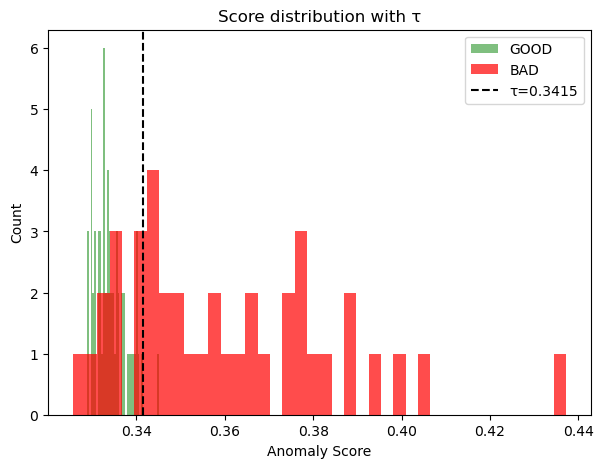

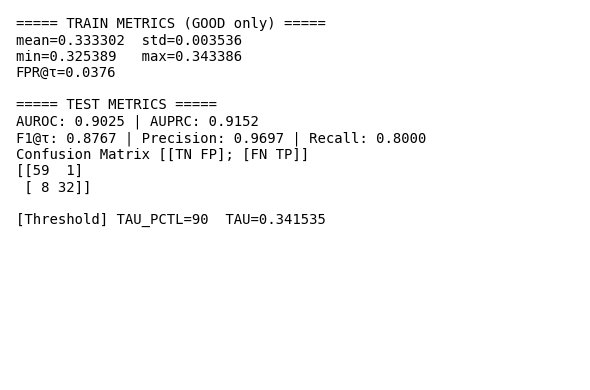

In [6]:
# =========================
# run
# =========================
# Stage1: bank (독립 RNG)
pca, bank_vecs, center_img_id, train_paths = stage1_build_bank(backbone, feats_cache, seed=SEED)

# Stage2: τ
tau = stage2_compute_tau(backbone, feats_cache, pca, bank_vecs, center_img_id, train_paths)

# Train metrics
scores_train = scores_for_paths(backbone, feats_cache, pca, bank_vecs, train_paths)
train_info = {
    "mean": float(scores_train.mean()),
    "std":  float(scores_train.std()),
    "min":  float(scores_train.min()),
    "max":  float(scores_train.max()),
    "fpr":  float((scores_train >= tau).mean()),
}

# Test metrics
test_good, test_bad = test_set_paths()
scores_test_good = scores_for_paths(backbone, feats_cache, pca, bank_vecs, test_good)
scores_test_bad  = scores_for_paths(backbone, feats_cache, pca, bank_vecs, test_bad)

scores_all = np.concatenate([scores_test_good, scores_test_bad])
y_true     = np.array([0]*len(scores_test_good) + [1]*len(scores_test_bad), np.int32)
y_pred     = (scores_all >= tau).astype(np.int32)

prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
test_info = {
    "auroc":     float(roc_auc_score(y_true, scores_all)) if len(np.unique(y_true))==2 else float("nan"),
    "aupr":      float(average_precision_score(y_true, scores_all)),
    "precision": float(prec),
    "recall":    float(rec),
    "f1":        float(f1),
    "cm":        confusion_matrix(y_true, y_pred)
}

# Outputs
plot_score_hist(scores_test_good, scores_test_bad, tau)   # Figure 1
plot_metrics_text(train_info, test_info, tau)             # Figure 2

### 5-1. GOOD & BAD Sample Visualization
- Displays original images with anomaly overlays and top-percent masks for both GOOD and BAD samples.

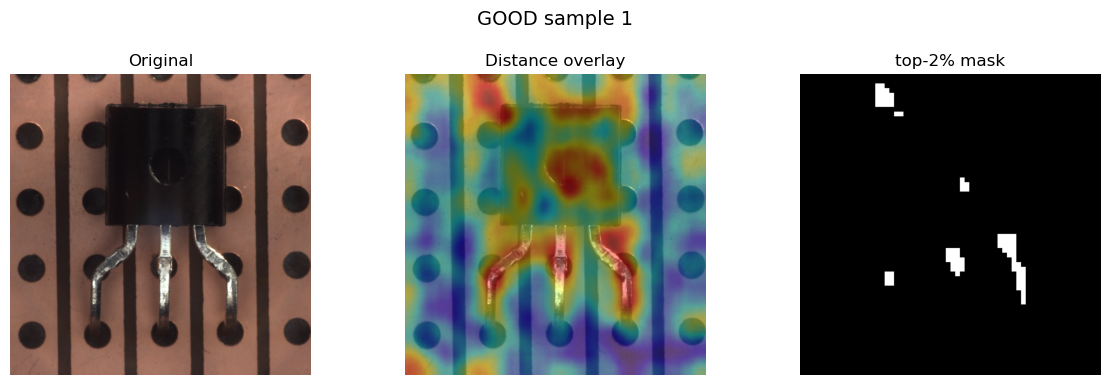

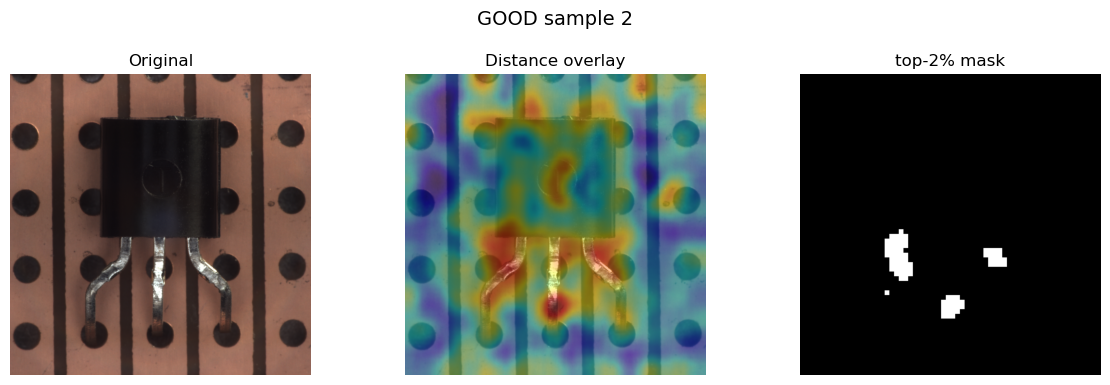

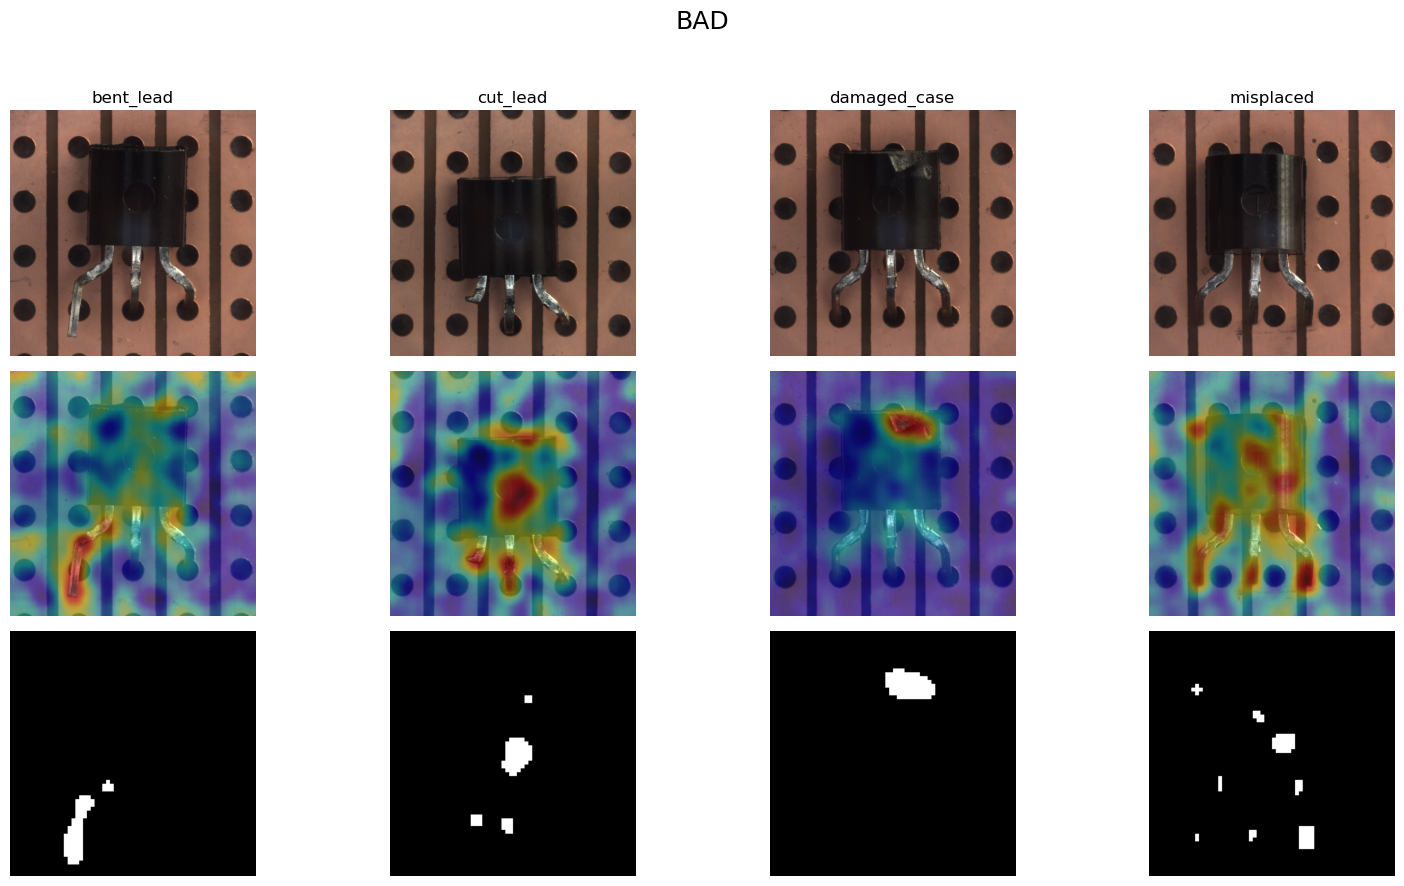

In [7]:
def _overlay_and_mask_from_dm(dm, img_bgr, top_p=TOP_PERCENT):
    H, W = img_bgr.shape[:2]
    dm = np.nan_to_num(dm.astype(np.float32))
    dm_blur = gaussian_blur(dm, GAUSS_KSIZE, GAUSS_SIGMA)
    dm_norm = (dm_blur - dm_blur.min()) / (dm_blur.ptp() + 1e-8)
    heat = cv2.applyColorMap((dm_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.resize(heat, (W, H), interpolation=cv2.INTER_CUBIC)
    overlay_bgr = cv2.addWeighted(img_bgr, 0.6, heat, 0.4, 0)
    k = max(1, int(dm_norm.size * top_p))
    th = np.partition(dm_norm.ravel(), -k)[-k]
    mask_small = (dm_norm >= th).astype(np.uint8) * 255
    mask = cv2.resize(mask_small, (W, H), interpolation=cv2.INTER_NEAREST)
    return overlay_bgr, mask

def viz_good_row(backbone, feats_cache, pca, index, indices=None, top_p=TOP_PERCENT):
    all_good_paths = list_images(os.path.join(TEST_DIR, "good"))
    if indices is None:
        indices = list(range(len(all_good_paths)))

    for disp_idx, i in enumerate(indices, start=1):   
        if i >= len(all_good_paths):
            print(f"Index {i} out of range, skip.")
            continue

        p = all_good_paths[i]
        img = load_bgr(p)
        emb, hw = extract_patch_embeddings(backbone, feats_cache, img)
        dm  = distance_map(index, apply_pca(pca, emb), hw, k=KNN_K)

        overlay_bgr, mask = _overlay_and_mask_from_dm(dm, img, top_p=top_p)
        orig    = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        overlay = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12,4))
        plt.suptitle(f"GOOD sample {disp_idx}", fontsize=14, y=0.95)  
        plt.subplot(1,3,1); plt.imshow(orig);    plt.axis("off"); plt.title("Original")
        plt.subplot(1,3,2); plt.imshow(overlay); plt.axis("off"); plt.title("Distance overlay")
        plt.subplot(1,3,3); plt.imshow(mask, cmap="gray"); plt.axis("off"); plt.title(f"top-{int(top_p*100)}% mask")
        plt.tight_layout(rect=[0, 0, 1, 0.92]); plt.show()


def viz_bad_three_rows(backbone, feats_cache, pca, index, n_per_class=1, top_p=TOP_PERCENT):
    items = []
    for d in sorted(Path(TEST_DIR).iterdir()):
        if d.is_dir() and d.name.lower() != "good":
            paths = list_images(str(d))[:n_per_class]
            items += [(d.name, p) for p in paths]
    if not items: print("No BAD images found."); raise SystemExit

    cols = len(items)
    fig = plt.figure(figsize=(4*cols, 9))
    fig.suptitle("BAD", fontsize=18, y=0.98)

    originals, overlays, masks, titles = [], [], [], []
    for cls_name, p in items:
        img = load_bgr(p)
        emb, hw = extract_patch_embeddings(backbone, feats_cache, img)
        dm  = distance_map(index, apply_pca(pca, emb), hw, k=KNN_K)
        overlay_bgr, mask = _overlay_and_mask_from_dm(dm, img, top_p=top_p)
        originals.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        overlays.append(cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB))
        masks.append(mask); titles.append(cls_name)

    for j, (im, t) in enumerate(zip(originals, titles)):
        ax = plt.subplot(3, cols, j + 1);           ax.imshow(im); ax.axis("off"); ax.set_title(t)
    for j, ov in enumerate(overlays):
        ax = plt.subplot(3, cols, cols + j + 1);     ax.imshow(ov); ax.axis("off")
    for j, mk in enumerate(masks):
        ax = plt.subplot(3, cols, 2*cols + j + 1);   ax.imshow(mk, cmap="gray"); ax.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# =======run========
index_bank = build_faiss_index(bank_vecs)

# 1) GOOD
viz_good_row(backbone, feats_cache, pca, index_bank, indices=[1, 4], top_p=0.02)

# 2) BAD
viz_bad_three_rows(backbone, feats_cache, pca, index_bank, n_per_class=1, top_p=0.02)